# Multi Modal Retrieval Augmented Generation

<img src="images/RAG.png" alt="Multi modal RAG Architecture" width="800"/>

<img src="images/clip.jpg" alt="CLIP (Contrastive Language–Image Pretraining)" width="800"/>

### Image souce : commons.wikimedia.org/ (Collections of the National Museum of African Art)

In [12]:
# !pip install langchain_openai
# !pip install langchain_core
# !pip install open_clip_torch
# !pip install chromadb
# !pip install matplotlib
# !pip install pillow
# !pip install pdfplumber
# !pip install nltk

In [1]:
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import chromadb
from chromadb.utils.data_loaders import ImageLoader
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
import tqdm as notebook_tqdm

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import hashlib
import pdfplumber
from typing import List, Dict
import nltk
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
image_list = []

for file_name in glob.glob("img/*.jpg"):
    image = Image.open(file_name)
    image_list.append(image)

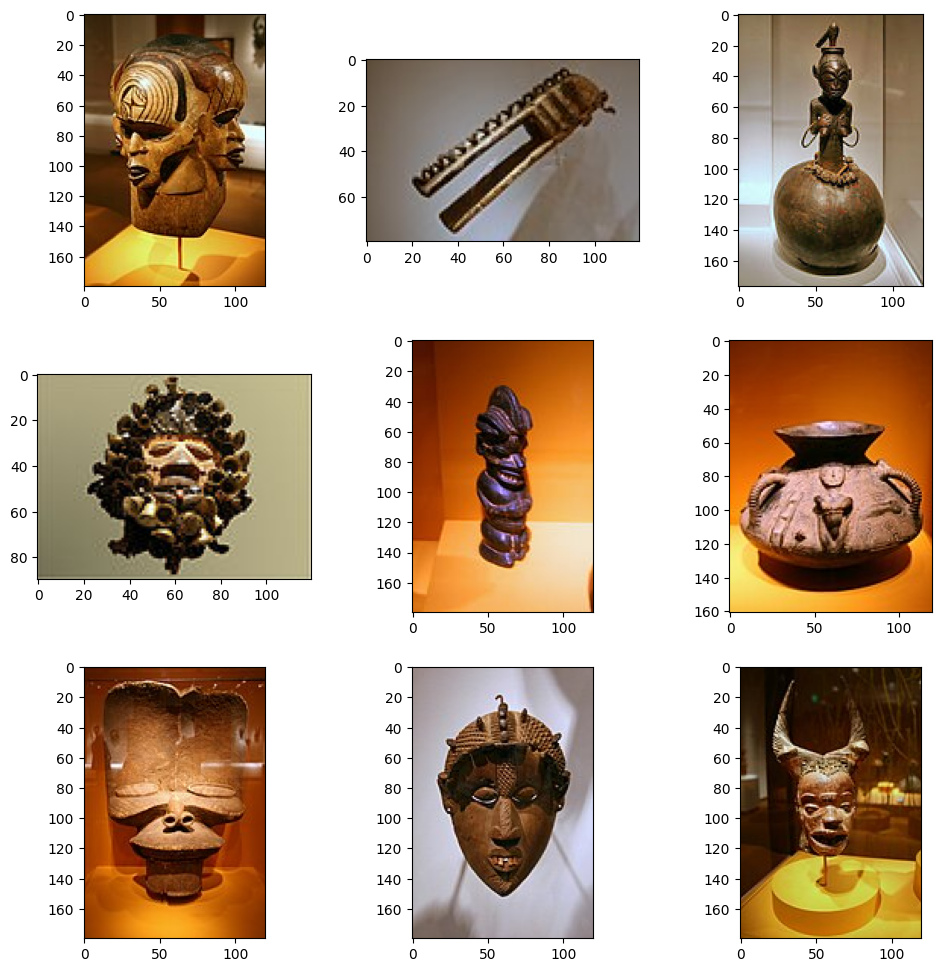

In [3]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12, 12))
img_to_show = [0, 3, 10, 22, 15, 2, 4, 8, 19]
axes = axes.flatten()

for img, ax in zip(img_to_show, axes):
   ax.imshow(image_list[img])

fig.show()

In [4]:
chromadb_client = chromadb.PersistentClient(path='Arts-store-vdb') # Create database vector

image_loader = ImageLoader()
clip_embedding_model = OpenCLIPEmbeddingFunction()
chromadb_vdb = chromadb_client.get_or_create_collection(
    name='Multimodal_arts',
    data_loader=image_loader,
    embedding_function=clip_embedding_model
    ) # Create collection (table)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def sha1_from_file(path: str) -> str:
    sha1 = hashlib.sha1()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            sha1.update(chunk)
    return sha1.hexdigest()


def sha1_from_text(text: str) -> str:
    return hashlib.sha1(text.encode("utf-8")).hexdigest()

In [6]:
print(len(os.listdir('img')))
print(len(os.listdir('Docs')))

102
102


In [12]:
images_uris = []
pdfs_uris = []
images_folder = 'img'
pdfs_folder = 'Docs'

for index, image_name in enumerate(sorted(os.listdir(images_folder))):
    image_path = os.path.join(images_folder, image_name)
    if 'jpg' in image_name:
        pdf_path = 'Docs/' + image_name.split('.jpg')[0] + '.pdf'
    if 'jpeg' in image_name:
        pdf_path = 'Docs/' + image_name.split('.jpeg')[0] + '.pdf'
        
    images_uris.append(image_path)
    pdfs_uris.append(pdf_path)

In [14]:
for i in range(5):
    print(images_uris[i], " : ", pdfs_uris[i])

img/120px-Akan_female_figure_on_a_gourd.jpg  :  Docs/120px-Akan_female_figure_on_a_gourd.pdf
img/120px-BamumMask.jpg  :  Docs/120px-BamumMask.pdf
img/120px-Bwa-serpent_mask.jpg  :  Docs/120px-Bwa-serpent_mask.pdf
img/120px-Chewa_jar.jpg  :  Docs/120px-Chewa_jar.pdf
img/120px-Dogon_female_figure.jpg  :  Docs/120px-Dogon_female_figure.pdf


In [9]:
class PDFProcessor:
    """
    - CLIP chunks : courts, descriptifs (pour retrieval multimodal)
    - LLM chunks  : riches, explicatifs (pour génération)
    """

    def __init__(
        self,
        clip_min_chars: int = 30,
        clip_max_chars: int = 250,
        llm_chunk_size: int = 800,
        llm_overlap: int = 100,
    ):
        self.clip_min_chars = clip_min_chars
        self.clip_max_chars = clip_max_chars
        self.llm_chunk_size = llm_chunk_size
        self.llm_overlap = llm_overlap

    # -------- TEXT EXTRACTION -------- #

    def extract_pages(self, pdf_path: str) -> List[str]:
        pages = []
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text = page.extract_text()
                if text:
                    pages.append(text)
        return pages

    # -------- CLIP CHUNKING -------- #

    def clip_chunks(self, text: str) -> List[str]:
        sentences = nltk.sent_tokenize(text)
        return [
            s.strip()
            for s in sentences
            if self.clip_min_chars <= len(s) <= self.clip_max_chars
        ]

    # -------- LLM CHUNKING -------- #

    def llm_chunks(self, text: str) -> List[str]:
        chunks = []
        start = 0
        while start < len(text):
            end = start + self.llm_chunk_size
            chunk = text[start:end]
            chunks.append(chunk.strip())
            start = end - self.llm_overlap
        return chunks

    # -------- MAIN PIPELINE -------- #

    def process(self, pdf_path: str, image_path: str):

        pdf_id = "pdf_" + sha1_from_file(pdf_path)
        image_id = "img_" + sha1_from_file(image_path)

        pages = self.extract_pages(pdf_path)

        clip_docs = []
        clip_ids = []
        clip_meta = []

        llm_chunks_store = {}  # llm_chunk_id -> texte

        for page_num, page_text in enumerate(pages, start=1):

            # 1️⃣ créer les LLM chunks
            llm_chunks = self.llm_chunks(page_text)

            for llm_idx, llm_text in enumerate(llm_chunks):
                llm_chunk_id = sha1_from_text(
                    f"{pdf_id}_p{page_num}_llm_{llm_idx}"
                )

                llm_chunks_store[llm_chunk_id] = llm_text

                # 2️⃣ CLIP chunks associés à CE LLM chunk
                for sentence in self.clip_chunks(llm_text):

                    clip_id = sha1_from_text(
                        f"{llm_chunk_id}_{sentence}"
                    )

                    clip_docs.append(sentence)
                    clip_ids.append(clip_id)
                    clip_meta.append({
                        "type": "text",
                        "pdf_id": pdf_id,
                        "image_id": image_id,
                        "page": page_num,
                        "llm_chunk_id": llm_chunk_id
                    })

        return {
            "pdf_id": pdf_id,
            "image_id": image_id,
            "clip_docs": clip_docs,
            "clip_ids": clip_ids,
            "clip_meta": clip_meta,
            "llm_chunks_store": llm_chunks_store
        }

In [10]:
pdf_pross = PDFProcessor()
pages = pdf_pross.extract_pages('Docs/120px-Dogon_female_figure.pdf')
pages

["Nom : Figure féminine\nDescription : Figure féminine , peuple Dogon, Mali, XIXe-début XXe siècle, bois,\nincrustation\nLe corps et le bouchon labial représentent une figure féminine dogon. Les têtes multiples\nsuggèrent la nature fluide des nommo, êtres spirituels primordiaux au cœur de la\ncosmologie dogon. Le disque surmontant les têtes sert de surface d'autel pour les libations.\nCe type de figure a probablement été commandé pour protéger la famille (les têtes ont le\nregard tourné dans toutes les directions) et témoigner de l'importance de l'harmonie\nfamiliale. Les points de pigment rouge, blanc et noir au dos des figures et sur le pilier\ncentral sont inhabituels. Si les masques dogon présentent des motifs peints, les figures et\nles tabourets ont généralement des surfaces incrustées ou érodées, caractéristiques d'un\nusage rituel.\nDate de prise de l’image : 21 septembre 2008\nSource : Musée national d'art africain"]

In [25]:
prosess_pdf = pdf_pross.process('Docs/120px-Akan_female_figure_on_a_gourd.pdf', 'img/120px-Akan_female_figure_on_a_gourd.jpg')
prosess_pdf

#len(prosess_pdf['clip_docs'])

{'pdf_id': 'pdf_b4da53d05caff7dea772d6d4460ca08089019b43',
 'image_id': 'img_f1bb02e82687dce91addbfc1ec08ce2cd5b8cc0a',
 'clip_docs': ['Nom : Figure féminine sur une calebasse\nDescription : Figure féminine sur une calebasse, peuple Luba, République démocratique du\nGabon, fin du XIXe siècle - début du XXe siècle, bois.',
  "Les ornements représentant un poisson-chat, un croissant de lune et une étoile indiquent\nque ce vase a été commandé pour la tombe d'un chef ou d'un chef suprême.",
  "Les\ninstruments de musique évoquent le rôle du chef en tant que prêtre du culte ancestral royal\net revêtent de multiples significations liées aux proverbes, à l'histoire et aux relations\nhumaines.",
  'Les serpents, une vipère du Gabon et un boomslang, symbolisent le chef comme\nsouverain de la forêt et de la savane.',
  "Date de prise de l’image : 21 septembre 2008\nSource : Musée national d'art africain",
  "008\nSource : Musée national d'art africain"],
 'clip_ids': ['44cb8012100185b6e00bc2e195

In [37]:
pdf_pross = PDFProcessor()

for idx, pdf_uri in enumerate(pdfs_uris):
    prosess_pdf = pdf_pross.process(pdfs_uris[idx], images_uris[idx])
    
    chromadb_vdb.add(
        ids=prosess_pdf['image_id'],
        uris=images_uris[idx],
        metadatas=[{
            "type": "image",
            "uris": images_uris[idx],
            "image_id": prosess_pdf['image_id'],
            "pdf_id": prosess_pdf['pdf_id']
        }]
    )

    chromadb_vdb.add(
        ids=prosess_pdf['clip_ids'],
        # uris=[pdfs_uris[idx] for _ in range(len(prosess_pdf['clip_docs']))],
        documents=prosess_pdf['clip_docs'],
        metadatas=prosess_pdf['clip_meta']
    )
    

In [117]:
results = chromadb_vdb.query(query_texts=['cameroun'], n_results=5, include=['uris', 'distances', 'metadatas'])#, where={"type": "image"})

results

{'ids': [['0f4f988d697545624da6ca750eef01ecdaef1031',
   'e6dd652e0efb5bc6bd0367ccb2b972513ed6268a',
   'bbb55cfeb19a3f0179c831402f6223b1d11405f7',
   '02fd3f9f7eb729349ebdef6c7caea7b2ad5eab75',
   '82a6f2fd65a53e71a7e05cd11d6ddd2655ab5cb4']],
 'embeddings': None,
 'documents': None,
 'uris': [[None, None, None, None, None]],
 'included': ['uris', 'distances', 'metadatas'],
 'data': None,
 'metadatas': [[{'pdf_id': 'pdf_96e7fc9341787e07432ab279eac2aa44f4b66119',
    'llm_chunk_id': '0df0fe10acd41803fcf224e57e1321f68418e59e',
    'type': 'text',
    'image_id': 'img_29927222c23afb48db1a65e1995abeec68ee17ed',
    'page': 1},
   {'page': 1,
    'type': 'text',
    'pdf_id': 'pdf_53c1ea9b8e40998e23829e3876f5709548cf706c',
    'image_id': 'img_6decbb61fa624e5ef57c25382477884350810cb4',
    'llm_chunk_id': '735af7c9500a332ed1d5ddd99e1b619d9071e0ba'},
   {'llm_chunk_id': '87a8d83460f9a6310e7ad1d4d97e7dfde05622cb',
    'image_id': 'img_79d42b091ced39e656755a1fed4d9adacba4778a',
    'page': 1,


In [118]:
img_results = []
img_ids = []

for idx, result in enumerate(results['metadatas'][0]):
    img_ids.append(result['image_id'])
    if result['type'] == 'text':
        img_id = result['image_id']
        r = chromadb_vdb.get(
            where={"$and": [
                {"type": "image"},
                {"image_id": img_id}
            ]},
            include=["uris", "metadatas"]
        )
        img_results.append(r['uris'][0])
    else:
        img_results.append(results['uris'][0][idx])


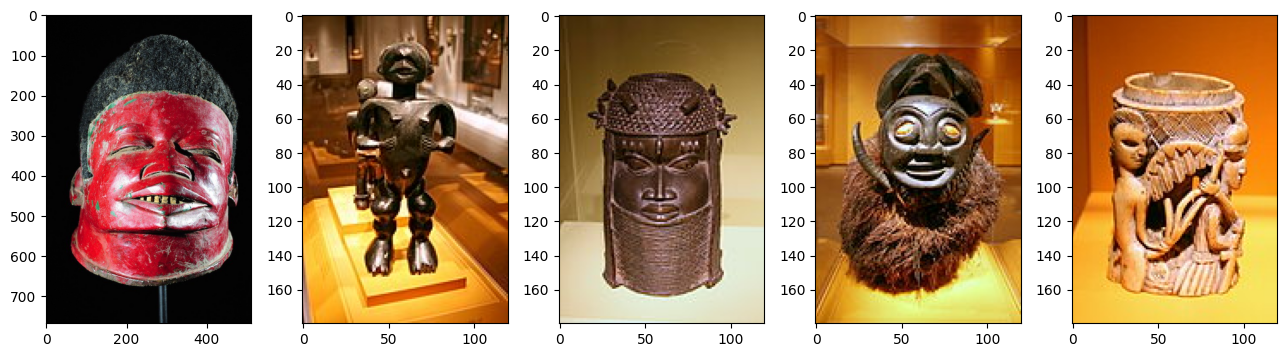

In [119]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize=(16, 4))
axes = axes.flatten()
for img, ax in zip(img_results, axes):
   ax.imshow(Image.open(img))

fig.show()

In [98]:
print(chromadb_vdb.count(), "images")

664 images
